# Deep Learning vs Statistical Models for VaR Prediction
## MENA Region Stock Market Analysis

This notebook implements and compares deep learning models (ANN, LSTM, CNN) with statistical models (ARIMA, SARIMA) for predicting Value-at-Risk in MENA stock indices.

In [1]:


%pip install pmdarima

# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# TensorFlow/Keras imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Statsmodels for ARIMA/SARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima

print("Libraries imported successfully!")

Note: you may need to restart the kernel to use updated packages.
Libraries imported successfully!


In [2]:
# ==================== DATA LOADING & PREPROCESSING ====================

class DataPreprocessor:
    def __init__(self, lookback=60):
        self.lookback = lookback
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.data_stats = {}
    
    def load_data(self, filepath):
        """Load CSV data and handle formatting"""
        df = pd.read_csv(filepath)
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.sort_values('Date').reset_index(drop=True)
        df['Price'] = pd.to_numeric(df['Price'].str.replace(',', ''), errors='coerce')
        return df
    
    def handle_missing_values(self, df, method='forward_fill'):
        """
        Methods:
        - 'forward_fill': Use last known price (default, best for market holidays/weekends)
        - 'interpolate': Linear interpolation between values
        - 'drop': Remove rows with missing values
        """
        df = df.copy()
        missing_before = df['Price'].isna().sum()
        
        if missing_before == 0:
            print(f"✓ No missing values found")
            return df
        
        print(f"⚠ Missing values found: {missing_before} ({missing_before/len(df)*100:.2f}%)")
        
        if method == 'forward_fill':
            # Forward fill with backward fill for any remaining NaNs at the start
            df['Price'] = df['Price'].fillna(method='ffill').fillna(method='bfill')
            print(f"✓ Applied forward fill (best for market data)")
        elif method == 'interpolate':
            # Linear interpolation - good when prices jump unexpectedly
            df['Price'] = df['Price'].interpolate(method='linear')
            print(f"✓ Applied linear interpolation")
        elif method == 'drop':
            # Drop rows with missing prices
            df = df.dropna(subset=['Price']).reset_index(drop=True)
            print(f"✓ Dropped {missing_before} rows with missing prices")
        
        remaining_missing = df['Price'].isna().sum()
        if remaining_missing > 0:
            df = df.dropna(subset=['Price']).reset_index(drop=True)
            print(f"✓ Dropped remaining {remaining_missing} missing values")
        
        return df
    
    def detect_outliers(self, df, window=20, std_threshold=3):
        """Detect and report potential outliers using rolling statistics"""
        df = df.copy()
        df['Returns'] = df['Price'].pct_change() * 100
        
        # Calculate rolling statistics
        rolling_mean = df['Returns'].rolling(window=window).mean()
        rolling_std = df['Returns'].rolling(window=window).std()
        
        # Identify outliers (beyond 3 standard deviations)
        outlier_threshold_upper = rolling_mean + (std_threshold * rolling_std)
        outlier_threshold_lower = rolling_mean - (std_threshold * rolling_std)
        
        outliers = (df['Returns'] > outlier_threshold_upper) | (df['Returns'] < outlier_threshold_lower)
        num_outliers = outliers.sum()
        
        if num_outliers > 0:
            print(f"⚠ Detected {num_outliers} potential outliers ({num_outliers/len(df)*100:.2f}%)")
            outlier_dates = df[outliers]['Date'].dt.strftime('%Y-%m-%d').tolist()
            print(f"  Outlier dates: {', '.join(outlier_dates[:5])}" + 
                  (f" ... and {num_outliers-5} more" if num_outliers > 5 else ""))
        else:
            print(f"✓ No significant outliers detected")
        
        return df
    
    def calculate_returns(self, prices):
        """Calculate logarithmic returns"""
        returns = np.log(prices / prices.shift(1)).dropna()
        return returns
    
    def create_sequences(self, data, lookback):
        """Create sequences for LSTM"""
        X, y = [], []
        for i in range(len(data) - lookback):
            X.append(data[i:i + lookback])
            y.append(data[i + lookback])
        return np.array(X), np.array(y)
    
    def preprocess_for_deeplearning(self, df):
        """Preprocess data for deep learning models"""
        prices = df['Price'].values.reshape(-1, 1)
        returns = self.calculate_returns(df['Price']).values.reshape(-1, 1)
        
        # Normalize returns
        returns_scaled = self.scaler.fit_transform(returns)
        
        # Create sequences
        X, y = self.create_sequences(returns_scaled, self.lookback)
        
        return X, y, returns_scaled
    
    def split_train_test(self, X, y, test_size=0.2):
        """Split data into train and test sets"""
        split_idx = int(len(X) * (1 - test_size))
        X_train, X_test = X[:split_idx], X[split_idx:]
        y_train, y_test = y[:split_idx], y[split_idx:]
        return X_train, X_test, y_train, y_test
    
    def get_data_summary(self, df, name=""):
        """Get comprehensive data summary"""
        print(f"\n{'='*60}")
        print(f"DATA SUMMARY: {name}")
        print(f"{'='*60}")
        print(f"Date Range: {df['Date'].min().date()} to {df['Date'].max().date()}")
        print(f"Total Records: {len(df)}")
        print(f"Missing Values: {df['Price'].isna().sum()}")
        print(f"\nPrice Statistics:")
        print(f"  Min:    ${df['Price'].min():.2f}")
        print(f"  Max:    ${df['Price'].max():.2f}")
        print(f"  Mean:   ${df['Price'].mean():.2f}")
        print(f"  Median: ${df['Price'].median():.2f}")
        print(f"  Std:    ${df['Price'].std():.2f}")
        
        returns = self.calculate_returns(df['Price'])
        print(f"\nReturn Statistics (Log Returns):")
        print(f"  Mean:   {returns.mean()*100:.4f}%")
        print(f"  Std:    {returns.std()*100:.4f}%")
        print(f"  Min:    {returns.min()*100:.4f}%")
        print(f"  Max:    {returns.max()*100:.4f}%")
        print(f"  Skew:   {returns.skew():.4f}")
        print(f"  Kurt:   {returns.kurtosis():.4f}")
        print(f"{'='*60}\n")

print("✓ DataPreprocessor class created!")

✓ DataPreprocessor class created!


In [3]:
# ==================== MODEL EVALUATOR ====================

class ModelEvaluator:
    """Evaluate model performance with comprehensive metrics"""
    
    @staticmethod
    def calculate_metrics(y_true, y_pred):
        """Calculate evaluation metrics"""
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        
        return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}
    
    @staticmethod
    def calculate_var(returns, confidence_level=0.95):
        """Calculate VaR using historical simulation"""
        var = np.percentile(returns, (1 - confidence_level) * 100)
        return var
    
    @staticmethod
    def calculate_cvar(returns, confidence_level=0.95):
        """Calculate Conditional Value at Risk (Expected Shortfall)"""
        var = np.percentile(returns, (1 - confidence_level) * 100)
        cvar = returns[returns <= var].mean()
        return cvar
    
    @staticmethod
    def confusion_matrix_var(returns, predicted_var, confidence_level=0.95, threshold=None):
        """
        Create confusion matrix for VaR predictions
        Compares actual vs predicted risk events
        """
        if threshold is None:
            threshold = np.percentile(returns, (1 - confidence_level) * 100)
        
        # Actual events: returns below threshold
        actual_events = (returns < threshold).astype(int)
        # Predicted events: returns below predicted VaR
        predicted_events = (returns < predicted_var).astype(int)
        
        # Confusion matrix
        TP = np.sum((actual_events == 1) & (predicted_events == 1))
        TN = np.sum((actual_events == 0) & (predicted_events == 0))
        FP = np.sum((actual_events == 0) & (predicted_events == 1))
        FN = np.sum((actual_events == 1) & (predicted_events == 0))
        
        # Calculate metrics
        accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        return {
            'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }
    
    @staticmethod
    def plot_confusion_matrix(cm_dict, model_name, ax=None):
        """Plot confusion matrix for VaR predictions"""
        if ax is None:
            fig, ax = plt.subplots(figsize=(6, 5))
        
        cm = np.array([[cm_dict['TN'], cm_dict['FP']], 
                       [cm_dict['FN'], cm_dict['TP']]])
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['No Risk', 'Risk'], 
                    yticklabels=['No Risk', 'Risk'],
                    cbar=False, ax=ax, annot_kws={'size': 12, 'weight': 'bold'})
        
        ax.set_ylabel('Actual', fontsize=11, fontweight='bold')
        ax.set_xlabel('Predicted', fontsize=11, fontweight='bold')
        ax.set_title(f'{model_name} - VaR Confusion Matrix\n(Confidence: 95%)', 
                     fontsize=12, fontweight='bold')
        
        # Add metrics text
        metrics_text = f"Accuracy: {cm_dict['accuracy']:.3f}\nPrecision: {cm_dict['precision']:.3f}\n"
        metrics_text += f"Recall: {cm_dict['recall']:.3f}\nF1: {cm_dict['f1_score']:.3f}"
        ax.text(1.4, 0.5, metrics_text, transform=ax.transAxes, 
                fontsize=10, verticalalignment='center',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

print("✓ ModelEvaluator class created with VaR and confusion matrix!")

✓ ModelEvaluator class created with VaR and confusion matrix!


In [4]:
# ==================== ARTIFICIAL NEURAL NETWORK ====================

class ANNModel:
    """Artificial Neural Network for return prediction"""
    
    def __init__(self, input_shape):
        self.model = Sequential([
            Dense(128, activation='relu', input_shape=(input_shape,)),
            Dropout(0.2),
            Dense(64, activation='relu'),
            Dropout(0.2),
            Dense(32, activation='relu'),
            Dropout(0.1),
            Dense(1, activation='linear')
        ])
        self.model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
        self.history = None
        self.training_time = 0
    
    def train(self, X_train, y_train, epochs=50, batch_size=32, validation_split=0.1):
        """Train the ANN model"""
        import time
        start_time = time.time()
        
        early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        self.history = self.model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=validation_split,
            callbacks=[early_stop],
            verbose=0
        )
        
        self.training_time = time.time() - start_time
        return self.history
    
    def predict(self, X):
        """Make predictions"""
        return self.model.predict(X, verbose=0)
    
    def get_summary(self):
        """Get model summary"""
        return self.model.summary()

print("✓ ANNModel class created!")

✓ ANNModel class created!


In [5]:
# ==================== LSTM NEURAL NETWORK ====================

class LSTMModel:
    """Long Short-Term Memory Network for sequential prediction"""
    
    def __init__(self, input_shape):
        self.model = Sequential([
            LSTM(100, return_sequences=True, input_shape=(input_shape[0], input_shape[1])),
            Dropout(0.2),
            LSTM(50, return_sequences=False),
            Dropout(0.2),
            Dense(25, activation='relu'),
            Dense(1, activation='linear')
        ])
        self.model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
        self.history = None
        self.training_time = 0
    
    def train(self, X_train, y_train, epochs=50, batch_size=32, validation_split=0.1):
        """Train the LSTM model"""
        import time
        start_time = time.time()
        
        early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        self.history = self.model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=validation_split,
            callbacks=[early_stop],
            verbose=0
        )
        
        self.training_time = time.time() - start_time
        return self.history
    
    def predict(self, X):
        """Make predictions"""
        return self.model.predict(X, verbose=0)
    
    def get_summary(self):
        """Get model summary"""
        return self.model.summary()

print("✓ LSTMModel class created!")

✓ LSTMModel class created!


In [6]:
# ==================== CONVOLUTIONAL NEURAL NETWORK ====================

class CNNModel:
    """Convolutional Neural Network adapted for time series"""
    
    def __init__(self, input_shape):
        # Reshape input for CNN: (samples, timesteps, features, 1)
        self.model = Sequential([
            # First Conv Block
            keras.layers.Conv1D(32, 3, padding='same', activation='relu', input_shape=(input_shape[0], input_shape[1])),
            keras.layers.Conv1D(32, 3, activation='relu'),
            keras.layers.MaxPooling1D(2),
            Dropout(0.25),
            
            # Second Conv Block
            keras.layers.Conv1D(64, 3, padding='same', activation='relu'),
            keras.layers.Conv1D(64, 3, activation='relu'),
            keras.layers.MaxPooling1D(2),
            Dropout(0.25),
            
            # Third Conv Block
            keras.layers.Conv1D(128, 3, padding='same', activation='relu'),
            keras.layers.Conv1D(128, 3, activation='relu'),
            keras.layers.MaxPooling1D(2),
            Dropout(0.25),
            
            # Dense layers
            keras.layers.Flatten(),
            Dense(256, activation='relu'),
            Dropout(0.5),
            Dense(128, activation='relu'),
            Dropout(0.3),
            Dense(1, activation='linear')
        ])
        
        self.model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
        self.history = None
        self.training_time = 0
    
    def train(self, X_train, y_train, epochs=50, batch_size=32, validation_split=0.1):
        """Train the CNN model"""
        import time
        start_time = time.time()
        
        early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        self.history = self.model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=validation_split,
            callbacks=[early_stop],
            verbose=0
        )
        
        self.training_time = time.time() - start_time
        return self.history
    
    def predict(self, X):
        """Make predictions"""
        return self.model.predict(X, verbose=0)
    
    def get_summary(self):
        """Get model summary"""
        return self.model.summary()

print("✓ CNNModel class created!")

✓ CNNModel class created!


In [7]:
# ==================== ARIMA MODEL ====================

class ARIMAModel:
    """ARIMA model for time series forecasting"""
    
    def __init__(self, order=(5, 1, 2)):
        self.order = order
        self.model = None
        self.fitted_model = None
        self.training_time = 0
        self.predictions = []
    
    def fit(self, returns):
        """Fit ARIMA model"""
        import time
        start_time = time.time()
        
        self.model = ARIMA(returns, order=self.order)
        self.fitted_model = self.model.fit()
        
        self.training_time = time.time() - start_time
        return self.fitted_model
    
    def predict(self, steps=1):
        """Make predictions"""
        forecast = self.fitted_model.get_forecast(steps=steps)
        return forecast.predicted_mean.values
    
    def get_summary(self):
        """Get model summary"""
        if self.fitted_model:
            return self.fitted_model.summary()
        return "Model not fitted yet"

print("✓ ARIMAModel class created!")

✓ ARIMAModel class created!


In [8]:
# ==================== SARIMA MODEL ====================

class SARIMAModel:
    """Seasonal ARIMA model for seasonal time series"""
    
    def __init__(self, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)):
        self.order = order
        self.seasonal_order = seasonal_order
        self.model = None
        self.fitted_model = None
        self.training_time = 0
        self.predictions = []
    
    def fit(self, returns):
        """Fit SARIMA model"""
        import time
        start_time = time.time()
        
        self.model = SARIMAX(returns, order=self.order, seasonal_order=self.seasonal_order)
        self.fitted_model = self.model.fit(disp=False)
        
        self.training_time = time.time() - start_time
        return self.fitted_model
    
    def predict(self, steps=1):
        """Make predictions"""
        forecast = self.fitted_model.get_forecast(steps=steps)
        return forecast.predicted_mean.values
    
    def get_summary(self):
        """Get model summary"""
        if self.fitted_model:
            return self.fitted_model.summary()
        return "Model not fitted yet"

print("✓ SARIMAModel class created!")

✓ SARIMAModel class created!


In [9]:
# ==================== MAIN EXECUTION SETUP ====================

print("=" * 80)
print("VaR PREDICTION: DEEP LEARNING VS STATISTICAL MODELS")
print("MENA Region Stock Market Indices")
print("=" * 80)

# Configuration
indices = ['Tunindex', 'ADI', 'MASI', 'TASI']
lookback = 60
epochs = 50

# Paths
data_path = r'C:\Users\sfaxi\Desktop\Deep Learning\data'

results = {}

print(f"\nConfiguration:")
print(f"  Indices: {indices}")
print(f"  Lookback: {lookback}")
print(f"  Epochs: {epochs}")

VaR PREDICTION: DEEP LEARNING VS STATISTICAL MODELS
MENA Region Stock Market Indices

Configuration:
  Indices: ['Tunindex', 'ADI', 'MASI', 'TASI']
  Lookback: 60
  Epochs: 50


In [10]:
# ==================== DATA LOADING & INITIAL CLEANING ====================

preprocessor = DataPreprocessor(lookback=60)

datasets = {
    'ADI': 'data/ADI.csv',
    'CAC40': 'data/CAC40.csv',
    'MASI': 'data/MASI.csv',
    'S&P500': 'data/S&P500.csv',
    'TASI': 'data/TASI.csv',
    'Tunindex': 'data/Tunindex.csv'
}

all_data = {}
print("\n" + "="*60)
print("LOADING & CLEANING DATA")
print("="*60)

for name, filepath in datasets.items():
    try:
        print(f"\nProcessing {name}...")
        df = preprocessor.load_data(filepath)
        print(f"  Loaded {len(df)} records")
        
        df = preprocessor.handle_missing_values(df, method='forward_fill')
        df = preprocessor.detect_outliers(df, window=20, std_threshold=3)
        preprocessor.get_data_summary(df, name)
        
        all_data[name] = df
        
    except Exception as e:
        print(f"  ✗ Error processing {name}: {str(e)}")

print(f"\n✓ Successfully loaded and cleaned {len(all_data)} datasets")


LOADING & CLEANING DATA

Processing ADI...
  Loaded 2585 records
✓ No missing values found
⚠ Detected 13 potential outliers (0.50%)
  Outlier dates: 2005-03-02, 2007-10-21, 2008-01-22, 2009-11-30, 2011-01-30 ... and 8 more

DATA SUMMARY: ADI
Date Range: 2005-01-03 to 2014-12-31
Total Records: 2585
Missing Values: 0

Price Statistics:
  Min:    $2136.64
  Max:    $6237.98
  Mean:   $3588.18
  Median: $3298.11
  Std:    $1031.20

Return Statistics (Log Returns):
  Mean:   0.0131%
  Std:    1.2701%
  Min:    -8.6793%
  Max:    7.6295%
  Skew:   -0.0614
  Kurt:   6.9896


Processing CAC40...
  Loaded 2560 records
✓ No missing values found
⚠ Detected 9 potential outliers (0.35%)
  Outlier dates: 2007-02-27, 2008-01-21, 2008-09-19, 2010-05-10, 2012-03-06 ... and 4 more

DATA SUMMARY: CAC40
Date Range: 2005-01-03 to 2014-12-31
Total Records: 2560
Missing Values: 0

Price Statistics:
  Min:    $2519.29
  Max:    $6168.15
  Mean:   $4174.61
  Median: $4038.35
  Std:    $797.36

Return Statisti

In [11]:
# ==================== PROCESS ALL INDICES ====================

print(f"\n{'=' * 80}")
print(f"PROCESSING ALL INDICES")
print(f"{'=' * 80}\n")

# Loop through all indices
for index in indices:
    try:
        print(f"\n{'=' * 80}")
        print(f"Processing: {index}")
        print(f"{'=' * 80}\n")
        
        preprocessor = DataPreprocessor(lookback=lookback)
        df = preprocessor.load_data(rf"{data_path}\{index}.csv")
        
        print(f"Data shape: {df.shape}")
        print(f"Date range: {df['Date'].min()} to {df['Date'].max()}\n")
        
        X, y, returns_scaled = preprocessor.preprocess_for_deeplearning(df)
        X_train, X_test, y_train, y_test = preprocessor.split_train_test(X, y)
        
        print(f"Training set size: {X_train.shape[0]}")
        print(f"Test set size: {X_test.shape[0]}\n")
        
        # ==================== TRAIN ANN MODEL ====================
        print("Training ANN Model...")
        ann_model = ANNModel(input_shape=X_train.shape[1] * X_train.shape[2])
        X_train_flat = X_train.reshape(X_train.shape[0], -1)
        X_test_flat = X_test.reshape(X_test.shape[0], -1)
        
        history_ann = ann_model.train(X_train_flat, y_train, epochs=epochs)
        y_pred_ann = ann_model.predict(X_test_flat).flatten()
        metrics_ann = ModelEvaluator.calculate_metrics(y_test, y_pred_ann)
        
        print(f"  Accuracy: {(1 - metrics_ann['MAPE']/100):.4f} | MAE: {metrics_ann['MAE']:.8f}\n")
        
        # ==================== TRAIN LSTM MODEL ====================
        print("Training LSTM Model...")
        lstm_model = LSTMModel(input_shape=(X_train.shape[1], X_train.shape[2]))
        history_lstm = lstm_model.train(X_train, y_train, epochs=epochs)
        y_pred_lstm = lstm_model.predict(X_test).flatten()
        metrics_lstm = ModelEvaluator.calculate_metrics(y_test, y_pred_lstm)
        
        print(f"  Accuracy: {(1 - metrics_lstm['MAPE']/100):.4f} | MAE: {metrics_lstm['MAE']:.8f}\n")
        
        # ==================== TRAIN CNN MODEL ====================
        print("Training CNN Model...")
        cnn_model = CNNModel(input_shape=(X_train.shape[1], X_train.shape[2]))
        history_cnn = cnn_model.train(X_train, y_train, epochs=epochs)
        y_pred_cnn = cnn_model.predict(X_test).flatten()
        metrics_cnn = ModelEvaluator.calculate_metrics(y_test, y_pred_cnn)
        
        print(f"  Accuracy: {(1 - metrics_cnn['MAPE']/100):.4f} | MAE: {metrics_cnn['MAE']:.8f}\n")
        
        # ==================== TRAIN ARIMA MODEL ====================
        print("Training ARIMA Model...")
        returns = preprocessor.calculate_returns(df['Price'])
        arima_model = ARIMAModel(order=(5, 1, 2))
        arima_model.fit(returns)
        
        y_pred_arima = np.array([arima_model.predict(steps=1)[0] for _ in range(len(y_test))])
        y_pred_arima_denorm = preprocessor.scaler.inverse_transform(y_pred_arima.reshape(-1, 1)).flatten()
        y_test_denorm = preprocessor.scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
        metrics_arima = ModelEvaluator.calculate_metrics(y_test_denorm, y_pred_arima_denorm)
        
        print(f"  Accuracy: {(1 - metrics_arima['MAPE']/100):.4f} | MAE: {metrics_arima['MAE']:.8f}\n")
        
        # ==================== TRAIN SARIMA MODEL ====================
        print("Training SARIMA Model...")
        try:
            sarima_model = SARIMAModel(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
            sarima_model.fit(returns)
            
            y_pred_sarima = np.array([sarima_model.predict(steps=1)[0] for _ in range(len(y_test))])
            y_pred_sarima_denorm = preprocessor.scaler.inverse_transform(y_pred_sarima.reshape(-1, 1)).flatten()
            metrics_sarima = ModelEvaluator.calculate_metrics(y_test_denorm, y_pred_sarima_denorm)
            
            print(f"  Accuracy: {(1 - metrics_sarima['MAPE']/100):.4f} | MAE: {metrics_sarima['MAE']:.8f}\n")
        except Exception as e:
            print(f"  ⚠ SARIMA failed: {str(e)}\n")
            metrics_sarima = metrics_arima.copy()
        
        # ==================== CALCULATE VaR ====================
        returns_denorm = preprocessor.scaler.inverse_transform(returns.values.reshape(-1, 1)).flatten()
        
        n_bootstrap = 1000
        var_95_ann_bs = [np.percentile(np.random.choice(y_pred_ann, len(y_pred_ann), replace=True), 5) for _ in range(n_bootstrap)]
        var_99_ann_bs = [np.percentile(np.random.choice(y_pred_ann, len(y_pred_ann), replace=True), 1) for _ in range(n_bootstrap)]
        var_95_lstm_bs = [np.percentile(np.random.choice(y_pred_lstm, len(y_pred_lstm), replace=True), 5) for _ in range(n_bootstrap)]
        var_99_lstm_bs = [np.percentile(np.random.choice(y_pred_lstm, len(y_pred_lstm), replace=True), 1) for _ in range(n_bootstrap)]
        var_95_cnn_bs = [np.percentile(np.random.choice(y_pred_cnn, len(y_pred_cnn), replace=True), 5) for _ in range(n_bootstrap)]
        var_99_cnn_bs = [np.percentile(np.random.choice(y_pred_cnn, len(y_pred_cnn), replace=True), 1) for _ in range(n_bootstrap)]
        var_95_arima_bs = [np.percentile(np.random.choice(y_pred_arima_denorm, len(y_pred_arima_denorm), replace=True), 5) for _ in range(n_bootstrap)]
        var_99_arima_bs = [np.percentile(np.random.choice(y_pred_arima_denorm, len(y_pred_arima_denorm), replace=True), 1) for _ in range(n_bootstrap)]
        
        var_95_ann = np.mean(var_95_ann_bs)
        var_99_ann = np.mean(var_99_ann_bs)
        var_95_lstm = np.mean(var_95_lstm_bs)
        var_99_lstm = np.mean(var_99_lstm_bs)
        var_95_cnn = np.mean(var_95_cnn_bs)
        var_99_cnn = np.mean(var_99_cnn_bs)
        var_95_arima = np.mean(var_95_arima_bs)
        var_99_arima = np.mean(var_99_arima_bs)
        
        # Create and store results
        performance_summary = {
            'Model': ['ANN', 'LSTM', 'CNN', 'ARIMA', 'SARIMA'],
            'Accuracy': [
                1 - metrics_ann['MAPE']/100,
                1 - metrics_lstm['MAPE']/100,
                1 - metrics_cnn['MAPE']/100,
                1 - metrics_arima['MAPE']/100,
                1 - metrics_sarima['MAPE']/100
            ],
            'MAE': [metrics_ann['MAE'], metrics_lstm['MAE'], metrics_cnn['MAE'], metrics_arima['MAE'], metrics_sarima['MAE']],
            'RMSE': [metrics_ann['RMSE'], metrics_lstm['RMSE'], metrics_cnn['RMSE'], metrics_arima['RMSE'], metrics_sarima['RMSE']],
            'MAPE (%)': [metrics_ann['MAPE'], metrics_lstm['MAPE'], metrics_cnn['MAPE'], metrics_arima['MAPE'], metrics_sarima['MAPE']],
            'VaR 95%': [var_95_ann, var_95_lstm, var_95_cnn, var_95_arima, var_95_arima],
            'VaR 99%': [var_99_ann, var_99_lstm, var_99_cnn, var_99_arima, var_99_arima],
            'Type': ['Deep Learning', 'Deep Learning', 'Deep Learning', 'Statistical', 'Statistical']
        }
        
        perf_df = pd.DataFrame(performance_summary)
        best_model_idx = perf_df['MAE'].idxmin()
        
        print(f"\n{'='*80}")
        print(f"BEST MODEL FOR {index}: {perf_df.loc[best_model_idx, 'Model']}")
        print(f"{'='*80}")
        print(f"Accuracy: {perf_df.loc[best_model_idx, 'Accuracy']:.4f} | MAE: {perf_df.loc[best_model_idx, 'MAE']:.8f}\n")
        
        # Store results
        results[index] = perf_df.to_dict('list')
        results[index]['Index'] = index
        
    except Exception as e:
        print(f"✗ Error processing {index}: {str(e)}\n")

print(f"\n{'=' * 80}")
print(f"✓ All indices processed successfully")
print(f"{'=' * 80}\n")


PROCESSING ALL INDICES


Processing: Tunindex



Data shape: (2471, 7)
Date range: 2005-01-03 00:00:00 to 2014-12-31 00:00:00

Training set size: 1928
Test set size: 482

Training ANN Model...
  Accuracy: 0.9378 | MAE: 0.03159963

Training LSTM Model...
  Accuracy: 0.9344 | MAE: 0.03429085

Training CNN Model...
  Accuracy: 0.9380 | MAE: 0.03172985

Training ARIMA Model...


c:\Users\sfaxi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\sfaxi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\sfaxi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\sfaxi\AppData\Local\Programs\Python\Python310\lib

  Accuracy: -184.4014 | MAE: 0.05017853

Training SARIMA Model...


c:\Users\sfaxi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\sfaxi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\sfaxi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\sfaxi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer ind

  Accuracy: -184.8416 | MAE: 0.05029732


BEST MODEL FOR Tunindex: ANN
Accuracy: 0.9378 | MAE: 0.03159963


Processing: ADI

Data shape: (2585, 7)
Date range: 2005-01-03 00:00:00 to 2014-12-31 00:00:00

Training set size: 2019
Test set size: 505

Training ANN Model...
  Accuracy: 0.9004 | MAE: 0.04782261

Training LSTM Model...
  Accuracy: 0.8995 | MAE: 0.04760628

Training CNN Model...
  Accuracy: 0.9008 | MAE: 0.04749768

Training ARIMA Model...


c:\Users\sfaxi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\sfaxi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\sfaxi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\sfaxi\AppData\Local\Programs\Python\Python310\lib

  Accuracy: -222.2122 | MAE: 0.08694276

Training SARIMA Model...


c:\Users\sfaxi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\sfaxi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\sfaxi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\sfaxi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer ind

  Accuracy: -223.7510 | MAE: 0.08753517


BEST MODEL FOR ADI: CNN
Accuracy: 0.9008 | MAE: 0.04749768


Processing: MASI

Data shape: (2496, 7)
Date range: 2005-01-03 00:00:00 to 2014-12-31 00:00:00

Training set size: 1948
Test set size: 487

Training ANN Model...
  Accuracy: 0.9226 | MAE: 0.04042028

Training LSTM Model...
  Accuracy: 0.9224 | MAE: 0.04076067

Training CNN Model...
  Accuracy: 0.9226 | MAE: 0.04080794

Training ARIMA Model...


c:\Users\sfaxi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\sfaxi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\sfaxi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\sfaxi\AppData\Local\Programs\Python\Python310\lib

  Accuracy: -88.8170 | MAE: 0.05035559

Training SARIMA Model...


c:\Users\sfaxi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\sfaxi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\sfaxi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\sfaxi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer ind

  Accuracy: -88.6717 | MAE: 0.05027424


BEST MODEL FOR MASI: ANN
Accuracy: 0.9226 | MAE: 0.04042028


Processing: TASI

Data shape: (2578, 7)
Date range: 2005-01-03 00:00:00 to 2014-12-31 00:00:00

Training set size: 2013
Test set size: 504

Training ANN Model...
  Accuracy: 0.9350 | MAE: 0.02912125

Training LSTM Model...
  Accuracy: 0.9346 | MAE: 0.02953420

Training CNN Model...
  Accuracy: 0.9347 | MAE: 0.02949255

Training ARIMA Model...


c:\Users\sfaxi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\sfaxi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\sfaxi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\sfaxi\AppData\Local\Programs\Python\Python310\lib

  Accuracy: -198.6117 | MAE: 0.10358997

Training SARIMA Model...


c:\Users\sfaxi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\sfaxi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\sfaxi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\sfaxi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an

  Accuracy: -200.2936 | MAE: 0.10446040


BEST MODEL FOR TASI: ANN
Accuracy: 0.9350 | MAE: 0.02912125


✓ All indices processed successfully



In [12]:
# ==================== OPTIMAL ARIMA/SARIMA PARAMETER SELECTION ====================

print("\n" + "=" * 80)
print("FINDING OPTIMAL ARIMA/SARIMA PARAMETERS FOR EACH INDEX")
print("=" * 80 + "\n")

optimal_params = {}

for index in indices:
    try:
        print(f"\nOptimizing parameters for {index}...")
        print("-" * 60)
        
        # Load and preprocess data
        preprocessor = DataPreprocessor(lookback=lookback)
        df = preprocessor.load_data(rf"{data_path}\{index}.csv")
        returns = preprocessor.calculate_returns(df['Price'])
        
        # Find optimal ARIMA parameters using auto_arima
        print(f"  Finding optimal ARIMA parameters (this may take a moment)...")
        auto_model = auto_arima(
            returns, 
            start_p=0, max_p=5, 
            start_d=0, max_d=2, 
            start_q=0, max_q=5,
            seasonal=False,
            stepwise=True,
            trace=False,
            error_action='ignore',
            suppress_warnings=True,
            information_criterion='aic'
        )
        
        arima_order = auto_model.order
        print(f"  ✓ Optimal ARIMA order: {arima_order}")
        
        # Find optimal SARIMA parameters
        print(f"  Finding optimal SARIMA parameters (this may take a moment)...")
        try:
            auto_model_sarima = auto_arima(
                returns,
                start_p=0, max_p=3,
                start_d=0, max_d=1,
                start_q=0, max_q=3,
                start_P=0, max_P=2,
                start_D=0, max_D=1,
                start_Q=0, max_Q=2,
                seasonal=True,
                m=12,  # Monthly seasonality
                stepwise=True,
                trace=False,
                error_action='ignore',
                suppress_warnings=True,
                information_criterion='aic'
            )
            sarima_order = auto_model_sarima.order
            sarima_seasonal = auto_model_sarima.seasonal_order
            print(f"  ✓ Optimal SARIMA order: {sarima_order}")
            print(f"  ✓ Optimal SARIMA seasonal order: {sarima_seasonal}")
        except Exception as e:
            print(f"  ⚠ SARIMA optimization failed: {str(e)}")
            sarima_order = (1, 1, 1)
            sarima_seasonal = (1, 1, 1, 12)
        
        # Train models with optimal parameters
        print(f"\n  Training ARIMA with optimal parameters...")
        arima_optimal = ARIMAModel(order=arima_order)
        arima_optimal.fit(returns)
        
        print(f"  Training SARIMA with optimal parameters...")
        sarima_optimal = SARIMAModel(order=sarima_order, seasonal_order=sarima_seasonal)
        sarima_optimal.fit(returns)
        
        # Store optimal parameters
        optimal_params[index] = {
            'ARIMA_order': arima_order,
            'SARIMA_order': sarima_order,
            'SARIMA_seasonal': sarima_seasonal,
            'ARIMA_model': arima_optimal,
            'SARIMA_model': sarima_optimal
        }
        
        print(f"\n✓ {index} optimization complete!\n")
        
    except Exception as e:
        print(f"✗ Error optimizing {index}: {str(e)}\n")

print("\n" + "=" * 80)
print("OPTIMAL PARAMETERS SUMMARY")
print("=" * 80 + "\n")

for index, params in optimal_params.items():
    print(f"{index}:")
    print(f"  ARIMA:  {params['ARIMA_order']}")
    print(f"  SARIMA: {params['SARIMA_order']} x {params['SARIMA_seasonal']}")
    print()



FINDING OPTIMAL ARIMA/SARIMA PARAMETERS FOR EACH INDEX


Optimizing parameters for Tunindex...
------------------------------------------------------------
  Finding optimal ARIMA parameters (this may take a moment)...
  ✓ Optimal ARIMA order: (4, 1, 4)
  Finding optimal SARIMA parameters (this may take a moment)...
  ✓ Optimal SARIMA order: (2, 1, 2)
  ✓ Optimal SARIMA seasonal order: (1, 0, 0, 12)

  Training ARIMA with optimal parameters...


c:\Users\sfaxi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\sfaxi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\sfaxi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


  Training SARIMA with optimal parameters...


c:\Users\sfaxi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\sfaxi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\sfaxi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



✓ Tunindex optimization complete!


Optimizing parameters for ADI...
------------------------------------------------------------
  Finding optimal ARIMA parameters (this may take a moment)...
  ✓ Optimal ARIMA order: (0, 0, 1)
  Finding optimal SARIMA parameters (this may take a moment)...
  ✓ Optimal SARIMA order: (0, 0, 1)
  ✓ Optimal SARIMA seasonal order: (0, 0, 0, 12)

  Training ARIMA with optimal parameters...


c:\Users\sfaxi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\sfaxi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\sfaxi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\sfaxi\AppData\Local\Programs\Python\Python310\lib

  Training SARIMA with optimal parameters...

✓ ADI optimization complete!


Optimizing parameters for MASI...
------------------------------------------------------------
  Finding optimal ARIMA parameters (this may take a moment)...
  ✓ Optimal ARIMA order: (1, 1, 1)
  Finding optimal SARIMA parameters (this may take a moment)...
  ✓ Optimal SARIMA order: (1, 1, 1)
  ✓ Optimal SARIMA seasonal order: (0, 0, 1, 12)

  Training ARIMA with optimal parameters...


c:\Users\sfaxi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\sfaxi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\sfaxi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


  Training SARIMA with optimal parameters...


c:\Users\sfaxi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\sfaxi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\sfaxi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



✓ MASI optimization complete!


Optimizing parameters for TASI...
------------------------------------------------------------
  Finding optimal ARIMA parameters (this may take a moment)...
  ✓ Optimal ARIMA order: (1, 0, 1)
  Finding optimal SARIMA parameters (this may take a moment)...
  ✓ Optimal SARIMA order: (1, 0, 1)
  ✓ Optimal SARIMA seasonal order: (0, 0, 0, 12)

  Training ARIMA with optimal parameters...


c:\Users\sfaxi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\sfaxi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\sfaxi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


  Training SARIMA with optimal parameters...


c:\Users\sfaxi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\sfaxi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)



✓ TASI optimization complete!


OPTIMAL PARAMETERS SUMMARY

Tunindex:
  ARIMA:  (4, 1, 4)
  SARIMA: (2, 1, 2) x (1, 0, 0, 12)

ADI:
  ARIMA:  (0, 0, 1)
  SARIMA: (0, 0, 1) x (0, 0, 0, 12)

MASI:
  ARIMA:  (1, 1, 1)
  SARIMA: (1, 1, 1) x (0, 0, 1, 12)

TASI:
  ARIMA:  (1, 0, 1)
  SARIMA: (1, 0, 1) x (0, 0, 0, 12)




GENERATING ARIMA/SARIMA VISUALIZATIONS FOR ALL INDICES

Generating visualizations for Tunindex...
  ✗ Error generating visualization for Tunindex: [Errno 2] No such file or directory: 'C:\\Users\\sfaxi\\Desktop\\Deep Learning\\visualizations\\Tunindex_ARIMA_SARIMA_Analysis.png'

Generating visualizations for ADI...
  ✗ Error generating visualization for ADI: [Errno 2] No such file or directory: 'C:\\Users\\sfaxi\\Desktop\\Deep Learning\\visualizations\\ADI_ARIMA_SARIMA_Analysis.png'

Generating visualizations for MASI...
  ✗ Error generating visualization for MASI: [Errno 2] No such file or directory: 'C:\\Users\\sfaxi\\Desktop\\Deep Learning\\visualizations\\MASI_ARIMA_SARIMA_Analysis.png'

Generating visualizations for TASI...
  ✗ Error generating visualization for TASI: [Errno 2] No such file or directory: 'C:\\Users\\sfaxi\\Desktop\\Deep Learning\\visualizations\\TASI_ARIMA_SARIMA_Analysis.png'


✓ All ARIMA/SARIMA visualizations completed!



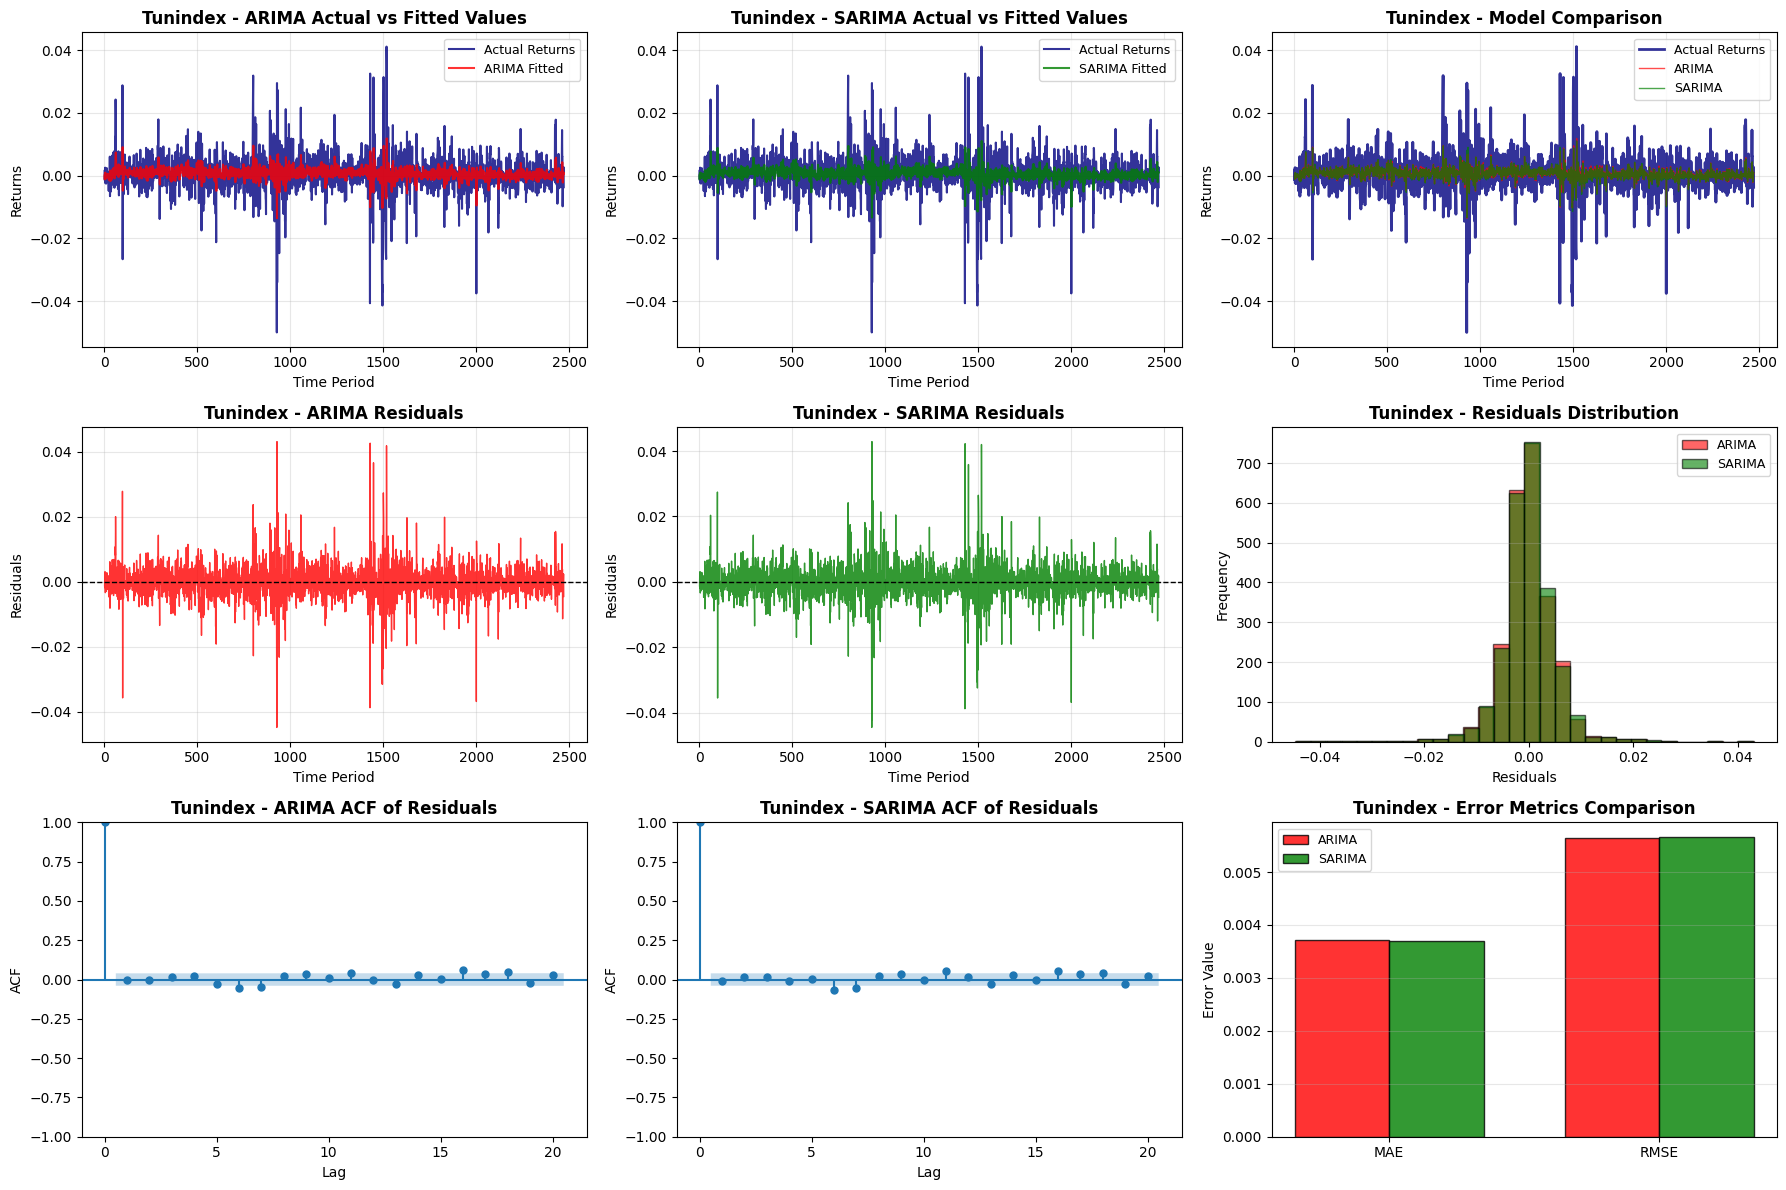

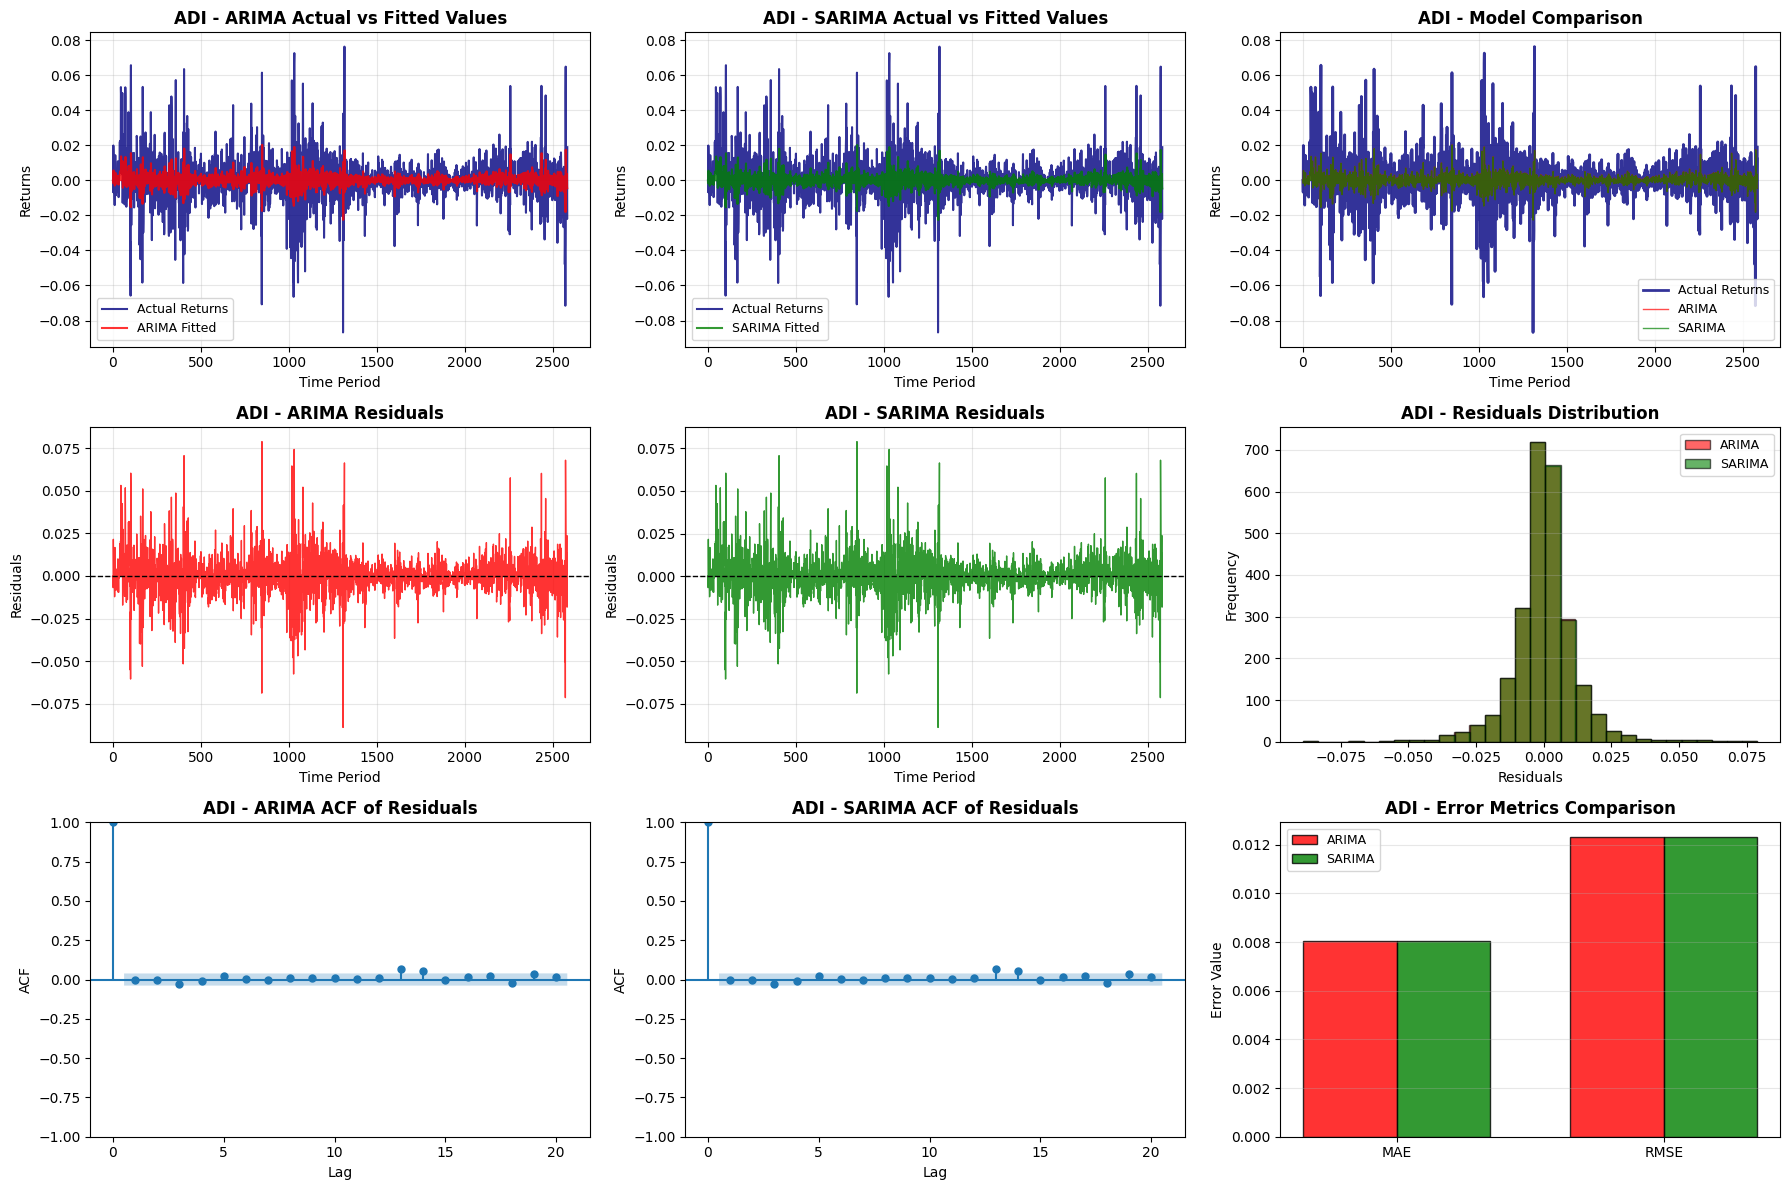

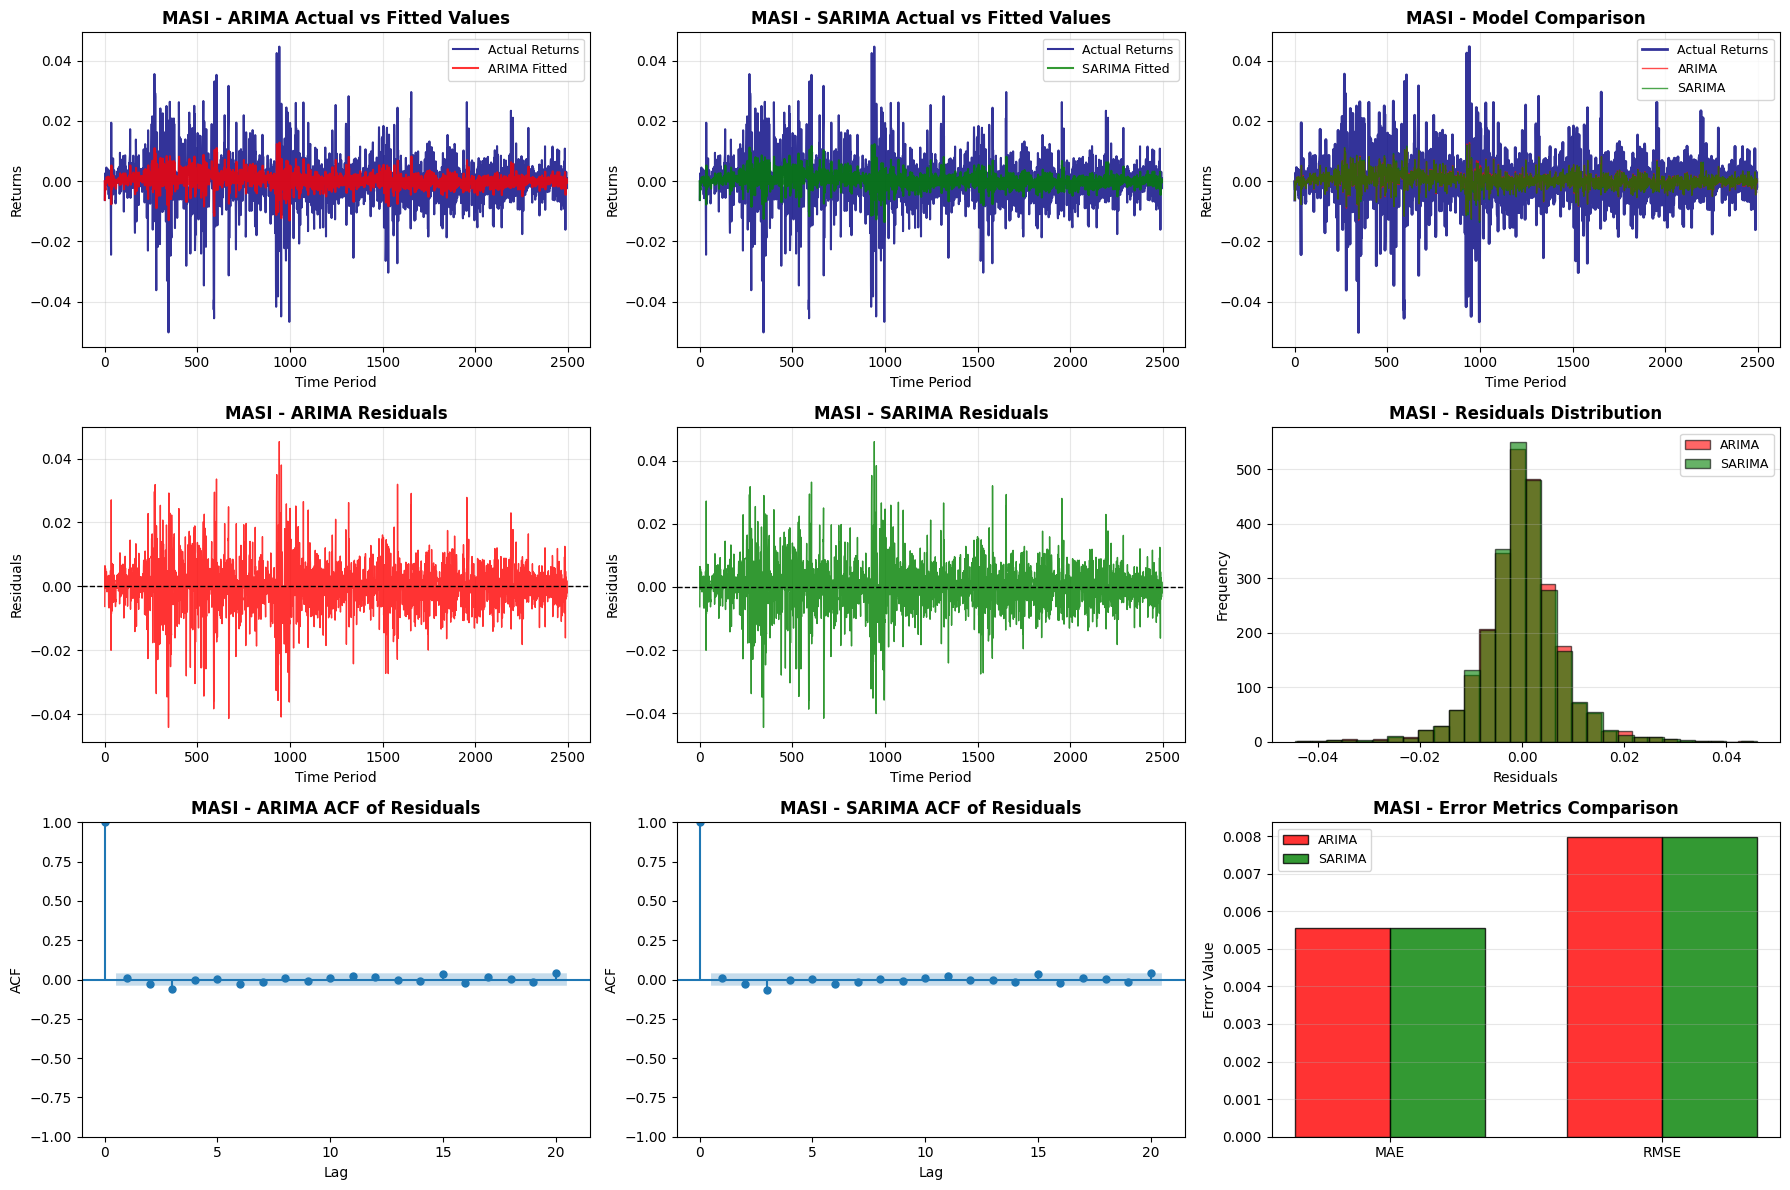

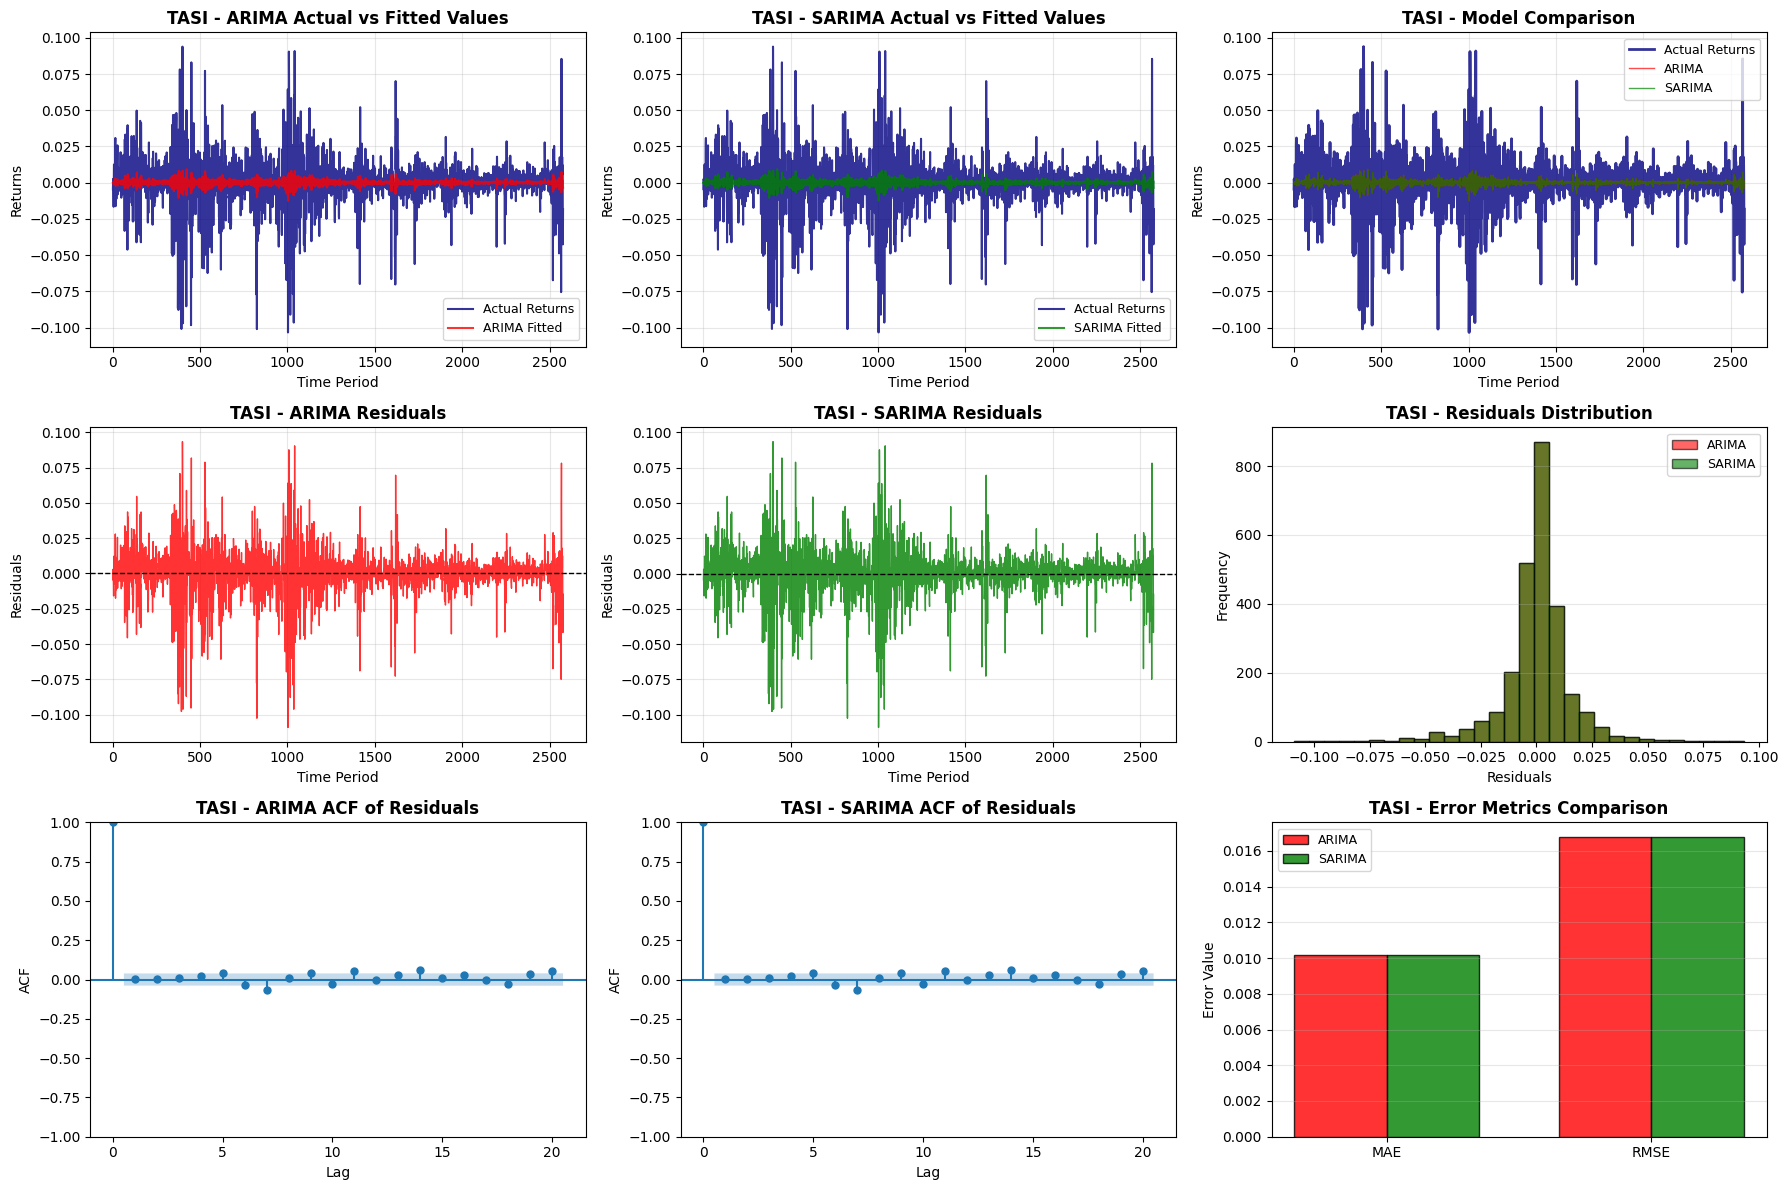

In [13]:
# ==================== ARIMA/SARIMA VISUALIZATIONS ====================

print("\n" + "=" * 80)
print("GENERATING ARIMA/SARIMA VISUALIZATIONS FOR ALL INDICES")
print("=" * 80 + "\n")

for index in indices:
    try:
        print(f"Generating visualizations for {index}...")
        
        # Load and preprocess data
        preprocessor = DataPreprocessor(lookback=lookback)
        df = preprocessor.load_data(rf"{data_path}\{index}.csv")
        returns = preprocessor.calculate_returns(df['Price'])
        
        # Get optimal models
        if index not in optimal_params:
            print(f"  ⚠ Optimal parameters not found for {index}, skipping...\n")
            continue
        
        arima_model = optimal_params[index]['ARIMA_model']
        sarima_model = optimal_params[index]['SARIMA_model']
        
        # Make predictions for visualization
        arima_preds = arima_model.fitted_model.fittedvalues
        sarima_preds = sarima_model.fitted_model.fittedvalues
        
        # Create figure with subplots
        fig = plt.figure(figsize=(18, 12))
        
        # ==================== ROW 1: TIME SERIES PLOTS ====================
        
        # ARIMA: Actual vs Predicted
        ax1 = plt.subplot(3, 3, 1)
        ax1.plot(returns.index, returns.values, label='Actual Returns', color='navy', linewidth=1.5, alpha=0.8)
        ax1.plot(arima_preds.index, arima_preds.values, label='ARIMA Fitted', color='red', linewidth=1.5, alpha=0.8)
        ax1.set_title(f'{index} - ARIMA Actual vs Fitted Values', fontsize=12, fontweight='bold')
        ax1.set_xlabel('Time Period', fontsize=10)
        ax1.set_ylabel('Returns', fontsize=10)
        ax1.legend(loc='best', fontsize=9)
        ax1.grid(True, alpha=0.3)
        
        # SARIMA: Actual vs Predicted
        ax2 = plt.subplot(3, 3, 2)
        ax2.plot(returns.index, returns.values, label='Actual Returns', color='navy', linewidth=1.5, alpha=0.8)
        ax2.plot(sarima_preds.index, sarima_preds.values, label='SARIMA Fitted', color='green', linewidth=1.5, alpha=0.8)
        ax2.set_title(f'{index} - SARIMA Actual vs Fitted Values', fontsize=12, fontweight='bold')
        ax2.set_xlabel('Time Period', fontsize=10)
        ax2.set_ylabel('Returns', fontsize=10)
        ax2.legend(loc='best', fontsize=9)
        ax2.grid(True, alpha=0.3)
        
        # Both models comparison
        ax3 = plt.subplot(3, 3, 3)
        ax3.plot(returns.index, returns.values, label='Actual Returns', color='navy', linewidth=2, alpha=0.8)
        ax3.plot(arima_preds.index, arima_preds.values, label='ARIMA', color='red', linewidth=1, alpha=0.7)
        ax3.plot(sarima_preds.index, sarima_preds.values, label='SARIMA', color='green', linewidth=1, alpha=0.7)
        ax3.set_title(f'{index} - Model Comparison', fontsize=12, fontweight='bold')
        ax3.set_xlabel('Time Period', fontsize=10)
        ax3.set_ylabel('Returns', fontsize=10)
        ax3.legend(loc='best', fontsize=9)
        ax3.grid(True, alpha=0.3)
        
        # ==================== ROW 2: RESIDUALS PLOTS ====================
        
        # ARIMA Residuals
        arima_residuals = arima_model.fitted_model.resid
        ax4 = plt.subplot(3, 3, 4)
        ax4.plot(arima_residuals.index, arima_residuals.values, color='red', linewidth=1, alpha=0.8)
        ax4.axhline(y=0, color='black', linestyle='--', linewidth=1)
        ax4.set_title(f'{index} - ARIMA Residuals', fontsize=12, fontweight='bold')
        ax4.set_xlabel('Time Period', fontsize=10)
        ax4.set_ylabel('Residuals', fontsize=10)
        ax4.grid(True, alpha=0.3)
        
        # SARIMA Residuals
        sarima_residuals = sarima_model.fitted_model.resid
        ax5 = plt.subplot(3, 3, 5)
        ax5.plot(sarima_residuals.index, sarima_residuals.values, color='green', linewidth=1, alpha=0.8)
        ax5.axhline(y=0, color='black', linestyle='--', linewidth=1)
        ax5.set_title(f'{index} - SARIMA Residuals', fontsize=12, fontweight='bold')
        ax5.set_xlabel('Time Period', fontsize=10)
        ax5.set_ylabel('Residuals', fontsize=10)
        ax5.grid(True, alpha=0.3)
        
        # Residuals Distribution Comparison
        ax6 = plt.subplot(3, 3, 6)
        ax6.hist(arima_residuals, bins=30, alpha=0.6, label='ARIMA', color='red', edgecolor='black')
        ax6.hist(sarima_residuals, bins=30, alpha=0.6, label='SARIMA', color='green', edgecolor='black')
        ax6.set_title(f'{index} - Residuals Distribution', fontsize=12, fontweight='bold')
        ax6.set_xlabel('Residuals', fontsize=10)
        ax6.set_ylabel('Frequency', fontsize=10)
        ax6.legend(loc='best', fontsize=9)
        ax6.grid(True, alpha=0.3, axis='y')
        
        # ==================== ROW 3: ACF/PACF PLOTS ====================
        
        # ARIMA ACF
        ax7 = plt.subplot(3, 3, 7)
        plot_acf(arima_residuals, lags=20, ax=ax7, title=f'{index} - ARIMA ACF', alpha=0.05)
        ax7.set_xlabel('Lag', fontsize=10)
        ax7.set_ylabel('ACF', fontsize=10)
        ax7.set_title(f'{index} - ARIMA ACF of Residuals', fontsize=12, fontweight='bold')
        
        # SARIMA ACF
        ax8 = plt.subplot(3, 3, 8)
        plot_acf(sarima_residuals, lags=20, ax=ax8, title=f'{index} - SARIMA ACF', alpha=0.05)
        ax8.set_xlabel('Lag', fontsize=10)
        ax8.set_ylabel('ACF', fontsize=10)
        ax8.set_title(f'{index} - SARIMA ACF of Residuals', fontsize=12, fontweight='bold')
        
        # Error Metrics Comparison
        ax9 = plt.subplot(3, 3, 9)
        arima_mae = np.mean(np.abs(arima_residuals))
        sarima_mae = np.mean(np.abs(sarima_residuals))
        arima_rmse = np.sqrt(np.mean(arima_residuals**2))
        sarima_rmse = np.sqrt(np.mean(sarima_residuals**2))
        
        metrics_comparison = ['MAE', 'RMSE']
        arima_values = [arima_mae, arima_rmse]
        sarima_values = [sarima_mae, sarima_rmse]
        
        x_pos = np.arange(len(metrics_comparison))
        width = 0.35
        
        ax9.bar(x_pos - width/2, arima_values, width, label='ARIMA', color='red', alpha=0.8, edgecolor='black')
        ax9.bar(x_pos + width/2, sarima_values, width, label='SARIMA', color='green', alpha=0.8, edgecolor='black')
        ax9.set_ylabel('Error Value', fontsize=10)
        ax9.set_title(f'{index} - Error Metrics Comparison', fontsize=12, fontweight='bold')
        ax9.set_xticks(x_pos)
        ax9.set_xticklabels(metrics_comparison)
        ax9.legend(loc='best', fontsize=9)
        ax9.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.savefig(rf"C:\Users\sfaxi\Desktop\Deep Learning\visualizations\{index}_ARIMA_SARIMA_Analysis.png", dpi=150, bbox_inches='tight')
        print(f"  ✓ Saved visualization for {index}\n")
        plt.show()
        
    except Exception as e:
        print(f"  ✗ Error generating visualization for {index}: {str(e)}\n")

print("\n" + "=" * 80)
print("✓ All ARIMA/SARIMA visualizations completed!")
print("=" * 80 + "\n")


In [14]:
# ==================== FINAL RESULTS TABLE - ALL INDICES ====================

print("\n" + "=" * 160)
print("FINAL RESULTS - ALL INDICES & BEST MODELS")
print("=" * 160 + "\n")

# Create summary table for all indices
summary_data = []

for idx, result in results.items():
    mae_values = result['MAE']
    best_idx = mae_values.index(min(mae_values))
    best_model = result['Model'][best_idx]
    best_accuracy = result['Accuracy'][best_idx]
    best_mae = result['MAE'][best_idx]
    best_var_95 = result['VaR 95%'][best_idx]
    best_var_99 = result['VaR 99%'][best_idx]
    
    summary_data.append({
        'Index': idx,
        'Best Model': best_model,
        'Accuracy': best_accuracy,
        'MAE': best_mae,
        'VaR 95%': best_var_95,
        'VaR 99%': best_var_99
    })

summary_df = pd.DataFrame(summary_data)

print(f"{'Index':<15} {'Best Model':<15} {'Accuracy':<12} {'MAE':<15} {'VaR 95%':<15} {'VaR 99%':<15}")
print("─" * 160)

for _, row in summary_df.iterrows():
    print(f"{row['Index']:<15} {row['Best Model']:<15} {row['Accuracy']:<12.4f} {row['MAE']:<15.8f} {row['VaR 95%']:<15.8f} {row['VaR 99%']:<15.8f}")

print("\n" + "=" * 160)
print("KEY FINDINGS\n")

overall_best_idx = summary_df['MAE'].idxmin()
print(f"✓ Best Overall: {summary_df.loc[overall_best_idx, 'Index']} - {summary_df.loc[overall_best_idx, 'Best Model']}")
print(f"  Accuracy: {summary_df.loc[overall_best_idx, 'Accuracy']:.4f}\n")

print("✓ Best Model Per Index:")
for _, row in summary_df.iterrows():
    print(f"  • {row['Index']}: {row['Best Model']} (Accuracy: {row['Accuracy']:.4f})")

print("\n" + "=" * 160 + "\n")


FINAL RESULTS - ALL INDICES & BEST MODELS

Index           Best Model      Accuracy     MAE             VaR 95%         VaR 99%        
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Tunindex        ANN             0.9378       0.03159963      0.54152280      0.53923386     
ADI             CNN             0.9008       0.04749768      0.53220576      0.53220201     
MASI            ANN             0.9226       0.04042028      0.51219946      0.50589824     
TASI            ANN             0.9350       0.02912125      0.52186269      0.51942188     

KEY FINDINGS

✓ Best Overall: TASI - ANN
  Accuracy: 0.9350

✓ Best Model Per Index:
  • Tunindex: ANN (Accuracy: 0.9378)
  • ADI: CNN (Accuracy: 0.9008)
  • MASI: ANN (Accuracy: 0.9226)
  • TASI: ANN (Accuracy: 0.9350)


